# Creating Model Age Spectra
 Example here is the model age spectra expect at an explored Curiosity site, telegraph peak 
 
 <nb>
    <nb>
- This notebook will create figure of the model mineralogy and the construct an age spectra from the diffusion kinetics that are found in the literature for each K-bearing phase with an assigned age given constraints from K-Ar measurement (Martin et al., (2017))

In [573]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("classic")
import seaborn as sns 
import pandas as pd

# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

In [574]:
# Murray Formation Mineralogy 
# Telegraph Peak 
plag = 27.1; san = 5.2; forsterite = 1.1; Pigeonite = 4.2; 
Orthopyroxene = 3.4; Magnetite = 8.2; Hematite = 1.1; 
Quartz = 0.9; Critobalite = 7.3; Jarosite = 1.5; 
Fluorapatite = 1.9; 
Opal_CT = 10.9; Amorphous = 27.2
import pandas as pd
df = pd.DataFrame({"Amorphous":[27.2],
                   "Plagioclase":[plag], 
                  "Sanidine": [san], 
                   "Jarosite": [1.5],
                  "Forsterote": [1.1], 
                  "Pigeonite": [4.2], 
                  "Orthopyroxene": [3.4], 
                  "Magnetite": [8.2], 
                  "Hematite": [1.1], 
                  "Quartz": [0.9], 
                  "Critobalite": [7.3],  
                  "Fluorapatite": [1.9], 
                  "Opal_CT":[10.9]})

In [575]:
# Cleaner Data Frame focussing on the minerals of interest
Other = 39
df2 = pd.DataFrame({"1 Jarosite": [1.5],
                    "2 Sanidine": [san],
                     "3 Plagioclase":[plag],
                    "Amorphous":[27.2],
                   "Non K-bearing phases":[39]})

# Model Mineralogy from XRD data 
* We highlight the K-bearing minerals and leave assign other to the non K-bearing phases

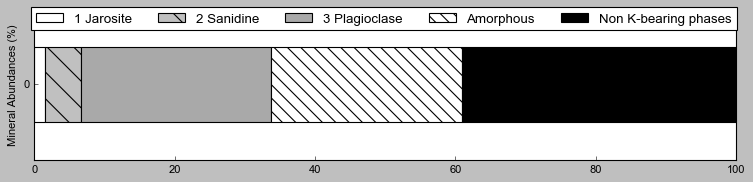

In [576]:
ax = plt.figure(figsize = (10,2.1)).add_subplot(111)
df2.plot.barh(ax = ax, stacked = True, 
             color = ['w', 'silver', 'darkgrey', 'w', 
                     'k'])
plt.ylabel('Mineral Abundances (%)')

bars = ax.patches
patterns =('', '\\', '', '\\\\')
hatches = [p for p in patterns for i in range(len(df2))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::1], labels[::1], bbox_to_anchor=(1.01, 1.058),
 ncol=5)

plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=1.5)
plt.savefig('Telegraph_Peak_Mineraogy.pdf')


# Fractional Release Equations 

In [577]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

# Age Equation

* Here we use theano to compute derivatives of the discretised fractional release equations

### Equation 1

In [578]:
import theano 
import theano.tensor as tt
from theano import pp 

In [579]:
def df1(ea, d0, a, temp, time): 
    x = tt.dvector('x') # Theano variable to differentiate w.r.t
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i 
    k = 6/(np.pi**(3/2))*np.sqrt(j*time)
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

def df2(ea, d0, a, temp, time): 
    x = tt.dvector('x')
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i
    k = (6/(np.pi**(3/2)))*np.sqrt(j*time) - (3/(np.pi**2))*j*time
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

def df3(ea, d0, a, temp, time): 
    x = tt.dvector('x')
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i 
    k =  1 - (6/np.pi**2)*np.exp(-j*time)
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

In [580]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

## Martian Step Heating Schedule and Diffusion Kientics

* Time and temperature of each step 
* Currently assume all grains have same radii, which is a definite oversimplication and may require changing and further reading on typical grain radii for both the mineral phases and on the surface of Mars


In [581]:
temp = np.linspace(200, 1670, 50) + 273.15
time = 300*np.ones(len(temp))
R = 8.314e-3

# Grain size (same for all)

a = 0.01 #(cm)

# Jarosite (Kula & Baldwin, 2011)
eaj = 158.1552
d0j = 5.68

# Plagioclase (Jourdan and Eroglu,2017)
eap = 190
d0p = 4

# Feldspar (Cassata and Renne, 2013) 
eaf = 225
d0f = 5



In [582]:
# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

# Jarosite 
* Cumulative Release
* Incremental Release

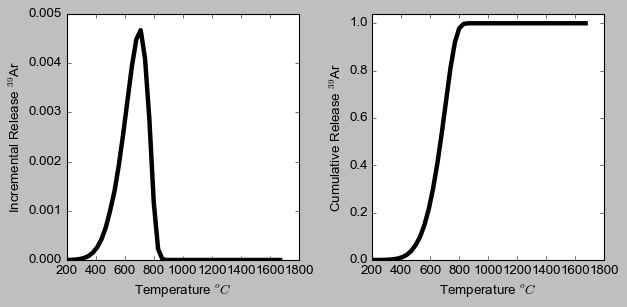

In [583]:
jj = fracrelx(eaj, d0j, a, temp, time).eval()
cc1 = Increment(eaj, d0j, a, temp, time).eval()


fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15, jj, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc1, lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')
plt.tight_layout()

# Plagioclase 

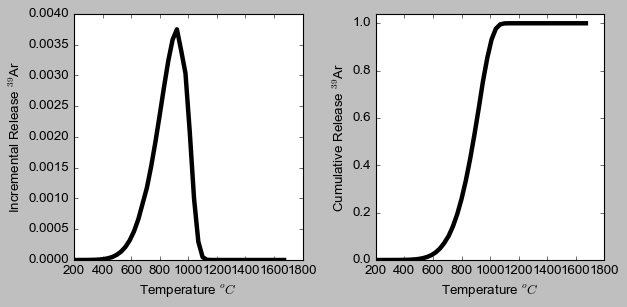

In [584]:
# Cumulative and Incremental Release

fp = fracrelx(eap, d0p, a, temp, time).eval()
cc2 = Increment(eap, d0p, a, temp, time).eval()

fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15,  fp, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc2[:len(temp)], lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')
plt.tight_layout()

# Feldspar

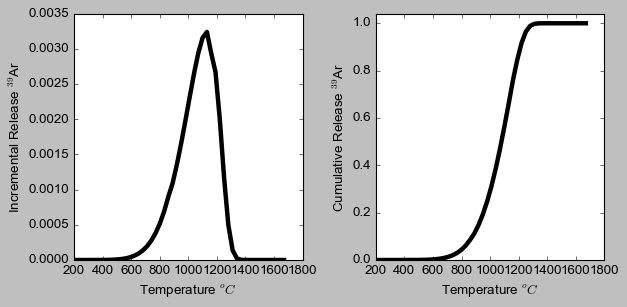

In [585]:
ff = fracrelx(eaf, d0f, a, temp, time).eval()
cc3 = Increment(eaf, d0f, a, temp, time).eval()

fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15,  ff, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc3[:len(temp)], lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')
plt.tight_layout()


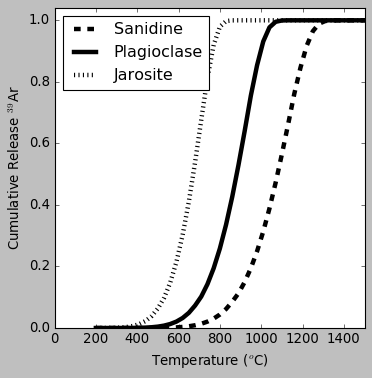

In [586]:
plt.style.use('classic')
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(temp - 273.15,  ff[:len(temp)], 
        lw = 4, color = 'k', ls = '--', 
       label = 'Sanidine')

ax.plot(temp - 273.15,  fp[:len(temp)], label = 'Plagioclase',
        lw = 4, color = 'k')
ax.plot(temp - 273.15, jj, 
        lw = 4, color = 'k' , ls = ':', 
       label = 'Jarosite')

ax.set_ylabel('Cumulative Release $^{39}$Ar')
ax.set_xlabel('Temperature ($^{o}$C)')

ax.set_ylim(0, 1.04)
ax.set_xlim(0, 1500)

ax.legend(loc = 'best')
plt.savefig('Cumulative_Release_TelePeak.pdf')

# Combined plot of all fractional and Cumulative releases

In [587]:
# Cumulative Mars 

# Incremental 
yyz = 0.05*cc1 + 0.75*cc2 + 0.2*cc3
x1 = cc1/yyz
x2 = cc2/yyz
x3 = cc3/yyz
yy = 0.05*x1*cc1 + 0.75*x2*cc2 + 0.2*x3*cc3

y = np.cumsum(yy)
X = y/y.max()
X1 = 0.05*jj + 0.75*fp + 0.2*ff

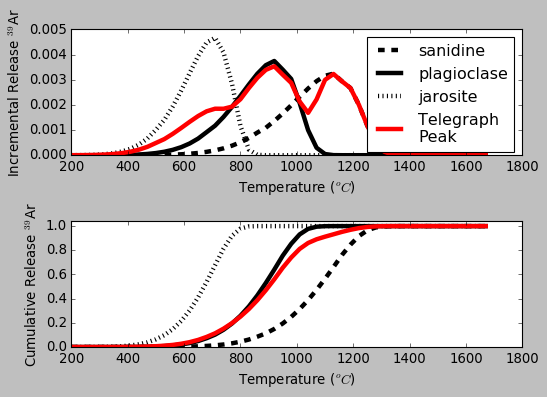

In [588]:
fig, ax = plt.subplots(2, 1, figsize = (7, 5))
ax[1].plot(temp - 273.15,  ff, 
        lw = 4, color = 'k', ls = '--')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc3, lw = 4, 
          color = 'k', ls = '--', 
          label = 'sanidine')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature ($^{o}C$)')


ax[1].plot(temp - 273.15,  fp, 
        lw = 4, color = 'k')

ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc2, lw = 4, 
          color = 'k', 
          label = 'plagioclase')


ax[1].plot(temp - 273.15, jj, 
        lw = 4, color = 'k' , ls = ':')

ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc1, lw = 4, 
          color = 'k', 
          ls = ":", 
          label = 'jarosite')


# Telegraph Peak 
ax[1].plot(temp - 273.15,  X1, 
        lw = 4, color = 'r', ls = '-')
ax[0].plot(temp - 273.15, yy, lw = 4, 
          color = 'r', ls = '-', 
          label = 'Telegraph\nPeak')

ax[0].legend(loc = 'best')


plt.tight_layout()
plt.savefig('TelegraphPeak_relcurves_2.pdf')

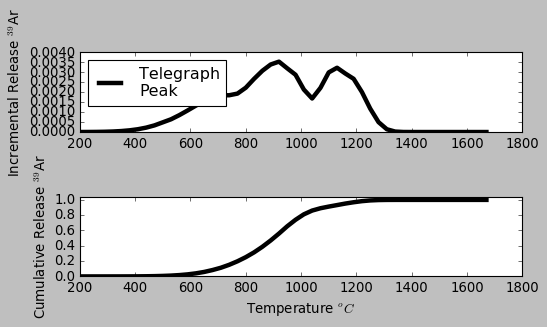

In [589]:
fig, ax = plt.subplots(2, 1, figsize = (7, 4))

ax[1].plot(temp - 273.15,  X1, 
        lw = 4, color = 'k', ls = '-')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, yy, lw = 4, 
          color = 'k', ls = '-', 
          label = 'Telegraph\nPeak')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].legend(loc = 2)
plt.tight_layout()

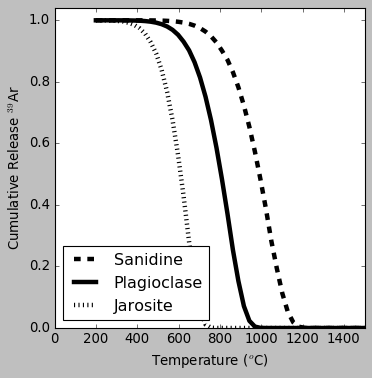

In [590]:

temp = np.linspace(200, 1500, 50) + 273.15
time = 1200*np.ones(len(temp))
ff = 1 - fracrelx(eaf, d0f, a, temp, time).eval()
jj = 1 - fracrelx(eaj, d0j, a, temp, time).eval()
fp = 1 - fracrelx(eap, d0p, a, temp, time).eval()


plt.style.use('classic')
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(temp - 273.15,  ff[:len(temp)], 
        lw = 4, color = 'k', ls = '--', 
       label = 'Sanidine')

ax.plot(temp - 273.15,  fp[:len(temp)], label = 'Plagioclase',
        lw = 4, color = 'k')
ax.plot(temp - 273.15, jj, 
        lw = 4, color = 'k' , ls = ':', 
       label = 'Jarosite')

ax.set_ylabel('Cumulative Release $^{39}$Ar')
ax.set_xlabel('Temperature ($^{o}$C)')

ax.set_ylim(0, 1.04)
ax.set_xlim(0, 1500)

ax.legend(loc = 'best')
plt.savefig('Cumulative_Release_TelePeak.pdf')

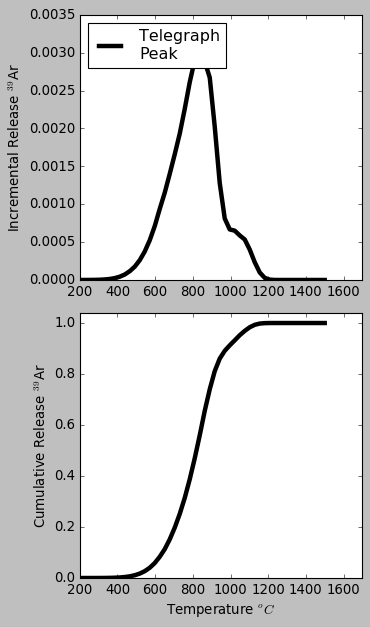

In [591]:

# Plotting Parameters Fonts

fig, ax = plt.subplots(2, 1, figsize = (5, 8))
ax[1].plot(temp - 273.15,  X1, 
        lw = 4, color = 'k', ls = '-')
#ax[1].plot(temp - 273.15,  X1, 
#        lw = 4, color = 'r', ls = '-')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')

ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, yyz, lw = 4, 
          color = 'k', ls = '-', 
          label = 'Telegraph\nPeak')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[0].legend(loc = 2)
plt.tight_layout()
ax[0].set_xlim(200, 1700)
ax[1].set_xlim(200, 1700)
plt.savefig('simultaneous_release.pdf')

In [592]:
# Error on Fractional Release curve 
err_f = np.random.normal(0.04, 0.002, len(X))

In [593]:
import theano 
from theano import shared
errf = shared(err_f)

# Age Spectra
* Forming the age spectra 
* Multi-component Age Spectra equation is given by the follow

$$ Age_{m} = \frac{\sum_{i = 1}^{k}\phi_{(i)} Age_{(i)} \frac{\delta F_{(i)}}{\delta T}}{\sum_{i = 1}^{k}\phi_{(i)} \frac{\delta F_{(i)}}{\delta T}}$$

* Age$_{m}$ is the observed Age spectra data
* $\phi$ - Volume fraction of each domain/sphere of each phase
* $\frac{\delta F_{(i)}}{\delta T}$ - Derivative of the cumulative release
* Age$_{i}$ - Age of each component

## Telegraph peak age spectra

In [627]:
temp = np.linspace(200, 1500, 20) + 273.15
time = 1200*np.ones(len(temp))
R = 8.314e-3

# Grain size (same for all)

a = 0.01 #(cm)

# Jarosite (Kula & Baldwin, 2011)
eaj = 158.1552
d0j = 5.68

# Plagioclase (Jourdan and Eroglu,2017)
eap = 190
d0p = 4

# Feldspar (Cassata and Renne, 2013) 
eaf = 225
d0f = 5

a1 = 2.1e9
a2 = 4.3e9
a3 = 4.1e9


c1 = Increment(eaj, d0j, a, temp, time).eval()
c2 = Increment(eap, d0p, a, temp, time).eval()
c3 = Increment(eaf, d0f, a, temp, time).eval()

y = 0.05*c1 + 0.75*c2 + 0.2*c3


ff = fracrelx(eaf, d0f, a, temp, time).eval()
jj = fracrelx(eaj, d0j, a, temp, time).eval()
fp = fracrelx(eap, d0p, a, temp, time).eval()


X = 0.05*jj + 0.75*fp + 0.2*ff

In [628]:
# Telegraph peak Age Spectra
age_m = 0.05*(c1*a1)/y + 0.75*(c2*a2)/y + 0.2*(c3*a3)/y


In [629]:
# Create Error for each step 
err = np.random.normal(100e6,20e6, len(age_m))

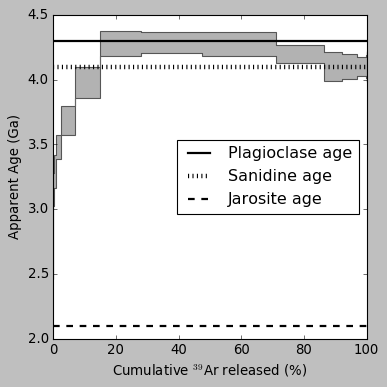

In [630]:
plt.figure(figsize = (5, 5))
plt.fill_between(X*100, age_m/1e9 - err/1e9, age_m/1e9 + err/1e9,
                step = 'pre', color ='grey', 
                 alpha = 0.6, edgecolor= 'k') 
plt.axhline(4.3,lw = 2, color = 'k', 
           ls = '-', 
           label = 'Plagioclase age')
plt.axhline(4.1,lw = 4, color = 'k', 
           ls = ':', 
           label = 'Sanidine age')
plt.axhline(2.1, lw = 2, color = 'k', 
           ls = '--', 
           label = 'Jarosite age')

plt.ylabel('Apparent Age (Ga)')
plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.legend(loc = 'best') 
plt.tight_layout()
plt.savefig('Tpeak_age_spec2.pdf')

# Sum of Squares Likelihood

In [631]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

class Sum_of_Squares(pm.distributions.Continuous):
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
        
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

# Age Spectra and Mineralogy 

In [632]:
# Age Spectra Model 
data = age_m 
fractional = X
data2 = fractional

In [633]:
import theano.tensor as tt
from theano import shared
age_err = shared(err*2)

In [634]:
N = data.shape[0]

In [635]:
TelePeak = pm.Model() 
with TelePeak: 
    
    # Mixing Fractions  
    phi = pm.Dirichlet('phi',
                       a = np.array([1, 1, 1]), 
                      shape = 3)
    # Diffusion Kinetics 
###################################################################### 
######################################################################
######################################################################
   # Activation Energy
    ea1 = pm.Normal('ea1', mu = 158,
                    sd = 3)
    ea2 = pm.Normal('ea2', mu = 190,
                    sd = 3)
    ea3 = pm.Normal('ea3', mu = 225,
                    sd = 3)
    
    # Frequency Factor
    d01 = pm.Lognormal('d01', mu = 5.8,
                       sd = 2)
    d02 = pm.Lognormal('d02', mu = 4,
                       sd = 2)
    d03 = pm.Lognormal('d03', mu = 5,
                       sd = 2)

###################################################################### 
######################################################################
######################################################################    

    # Grain sizes
    a1 = pm.Normal('a1', mu = 0.025, sd = 0.001)
    
    a2 = pm.Normal('a2', mu = 0.025, sd = 0.001)
    
    a3 = pm.Normal('a3', mu = 0.025, sd = 0.001)

In [637]:
with TelePeak: 
    # Ages For each K-bearing component in 
    # Telegraph Peak age spectra
    age1 = pm.Uniform('age1',  lower = 0.0,
                             upper = 4.6e9)
    
    age2 = pm.Uniform('age2',  lower = 0.0,
                             upper = 4.6e9)
    
    age3 = pm.Uniform('age3',  lower = 0.0,
                             upper = 4.6e9)

In [639]:
with TelePeak: 
    # Age Spectra
    # Incremental Release Curves for each component
    X = Increment(ea1, d01,
                  a1, temp, time)
    Y = Increment(ea2, d02,
                  a2, temp, time)
    Z = Increment(ea3, d03,
                  a3, temp, time)
    
    # Assign Mixing Fractions to each component
    m1 = phi[0]
    m2 = phi[1]
    m3 = phi[2]
    
    #Models
    WW = (m1*X + m2*Y + m3*Z)
    
    mu1 = (m1*X)/(WW); mu2 = (m2*Y)/(WW); mu3 = (m3*Z)/(WW)
    
    # Age spectra model
    model = mu1*age1 + mu2*age2 + mu3*age3
    
    # Age spectra error 
    age_model_error = pm.HalfNormal('age_model_error', 
                                    sd = data.mean()/10, 
                                    shape = N)


In [641]:
with TelePeak:
    # Cumulative Release Model 
    # Cumulative Release for each component
    A = fracrelx(ea1, d01,
                 a1, temp, time)
    B = fracrelx(ea2, d02,
                 a2, temp, time)
    C = fracrelx(ea3, d03,
                 a3, temp, time)
    # Fractional Release Model 
    model2 = m1*A + m2*B + m3*C
    
    # Fractional Release Model error
    f_err = pm.HalfNormal('f_err', 
                         sd = 0.02,
                         shape = N)

In [643]:
with TelePeak:
    age_model = pm.Deterministic('age_model', model)
    frel_model = pm.Deterministic('frel_model', model2)

In [645]:
with TelePeak: 
    # Lieklihoods 
    obs = Sum_of_Squares('obs', model, age_err, 
                         observed = data) 
    
    obs2 = pm.Normal('obs2', mu = model2, sd = f_err, 
                    observed = data2)

# Check Test Point

In [647]:
TelePeak.check_test_point()

a1                         5.99
a2                         5.99
a3                         5.99
age1_interval__           -1.39
age2_interval__           -1.39
age3_interval__           -1.39
age_model_error_log__    -15.40
d01_log__                 -1.61
d02_log__                 -1.61
d03_log__                 -1.61
ea1                       -2.02
ea2                       -2.02
ea3                       -2.02
f_err_log__              -15.40
obs                     -745.22
obs2                    -491.02
phi_stickbreaking__       -2.60
Name: Log-probability of test_point, dtype: float64

In [703]:
SAMPLES = 50000
BURN = 150000

with TelePeak: 
    step1 = pm.NUTS([phi])
    step2 = pm.Metropolis([f_err, age_model_error, 
                          age1, age2, age3, 
                          a1, a2, a3,d01, 
                          d02, d03,ea1, ea2, 
                          ea3])
    trace = pm.sample(SAMPLES,
                      tune = BURN,
                      step = pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [f_err]
>Metropolis: [age_model_error]
>Metropolis: [age3]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a3]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d03]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea3]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 2 chains: 100%|██████████| 400000/400000 [2:16:51<00:00, 48.71draws/s]        
The estimated number of effective samples is smaller than 200 for some parameters.


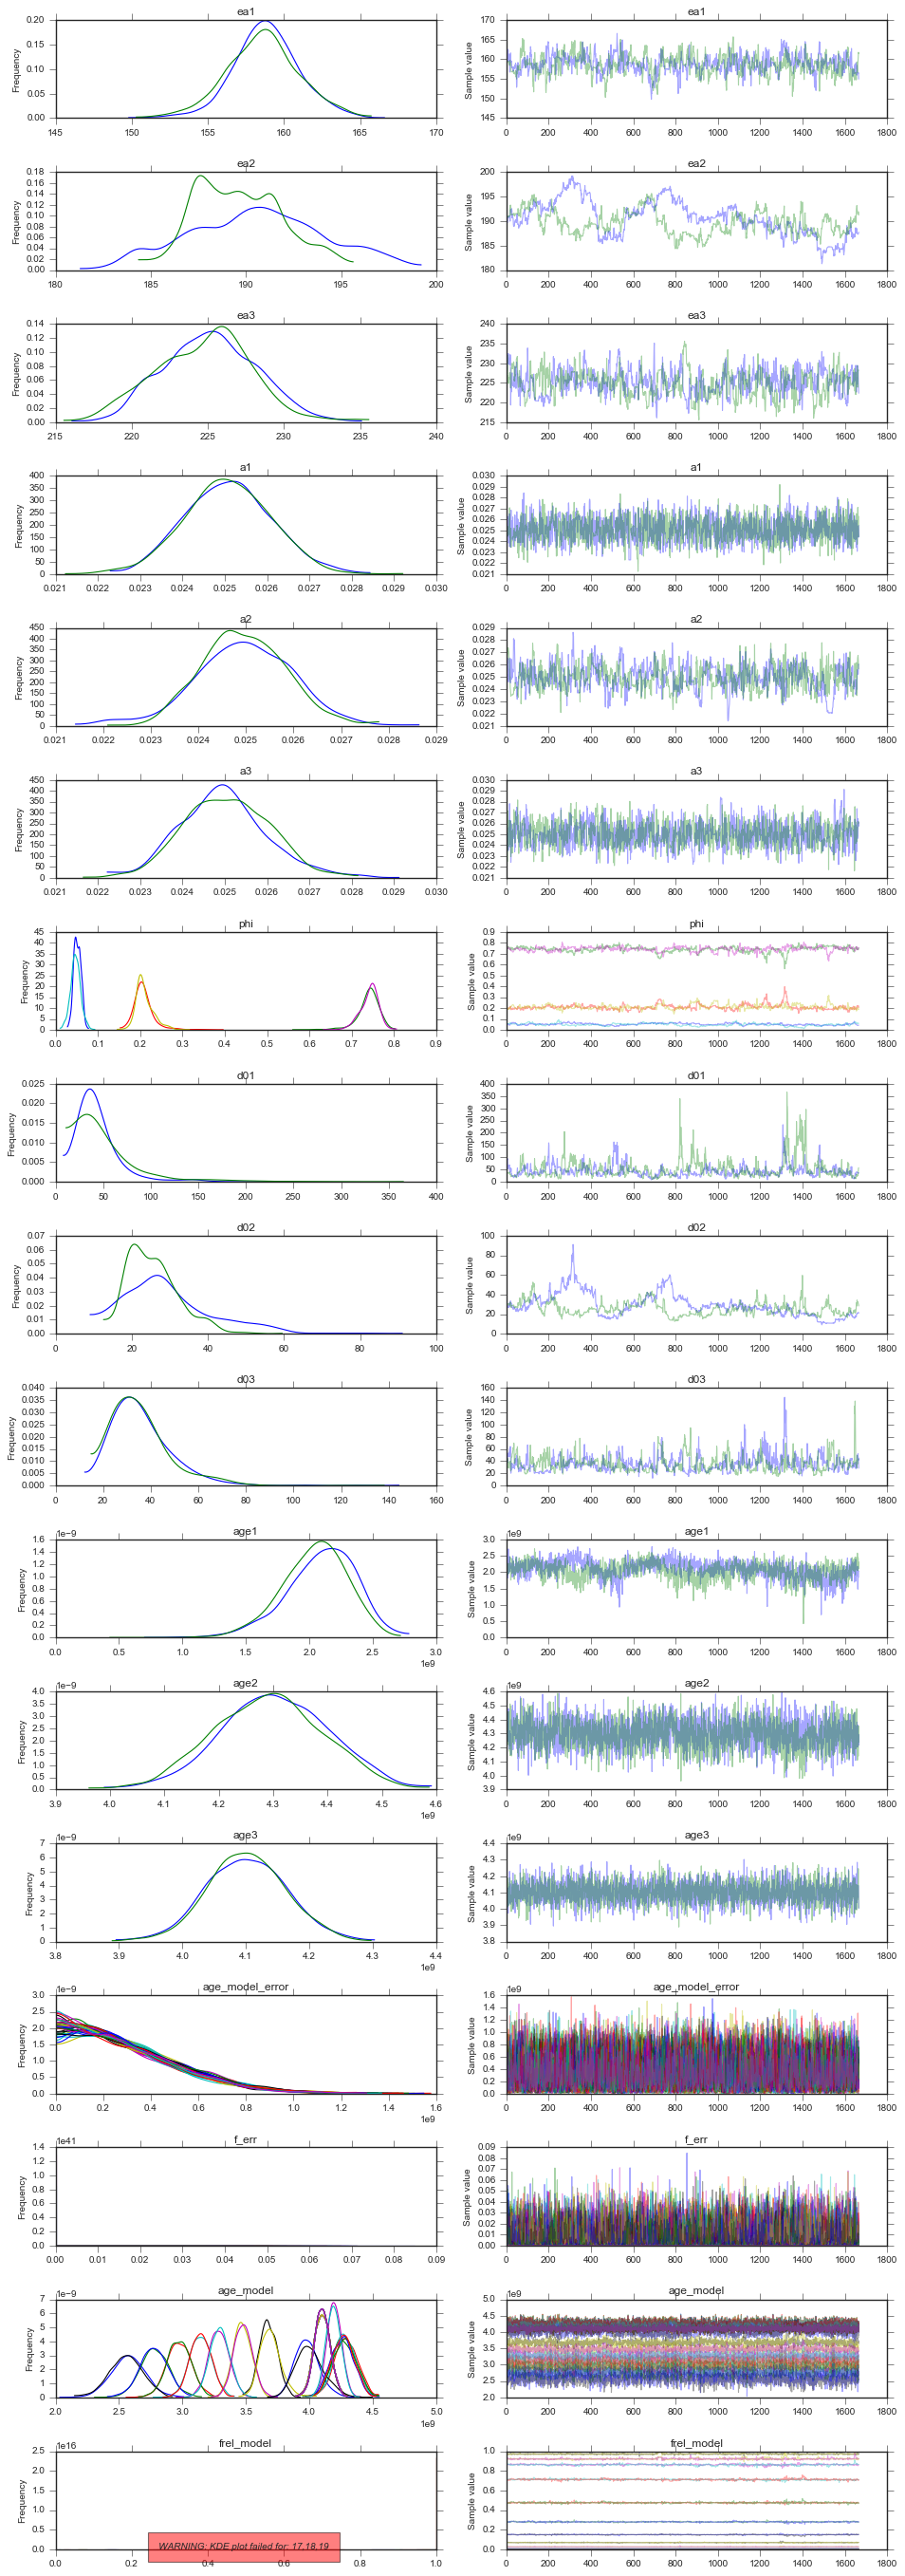

In [704]:
pm.traceplot(trace[-SAMPLES::30]); 

In [705]:
w = trace['age_model'].mean(axis = 0)
w2 = trace['frel_model'].mean(axis = 0)

low2, high2 = np.percentile(trace['frel_model'], [2.5, 97.5], axis = 0)
low, high = np.percentile(trace['age_model'], [2.5, 97.5], axis = 0)

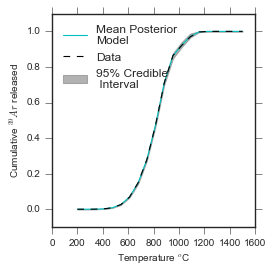

In [706]:
sns.set_style('ticks')
plt.figure(figsize = (3.5,3.5))
plt.plot(temp - 273.15, w2, 
        label = 'Mean Posterior \nModel', color = 'c', alpha = 1)
plt.plot(temp -273.15, data2, label = 'Data', color= 'k', ls= '--')
plt.fill_between(temp - 274.15, low2, high2, 
                color = 'grey', alpha =  0.6, 
                label = '95% Credible \n Interval')
plt.ylim(-0.1, 1.1)
plt.xlabel('Temperature $^{o}$C')
plt.ylabel('Cumulative $^{39}Ar$ released')
plt.legend(loc = 2)
plt.tight_layout()
plt.savefig('TelePeak_model_frel.pdf')

(<matplotlib.axes._subplots.AxesSubplot at 0x1c5a119c88>, GridSpec(2, 2))

<Figure size 240x240 with 0 Axes>

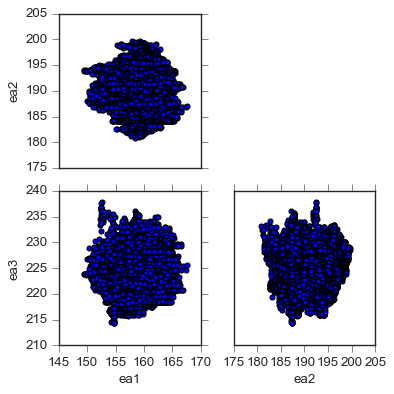

In [707]:
sns.set_style('ticks')
plt.figure(figsize = (3,3))
pm.pairplot(trace[-SAMPLES::2], 
           varnames = ['ea1', 'ea2', 'ea3'], 
           figsize = (5,5))

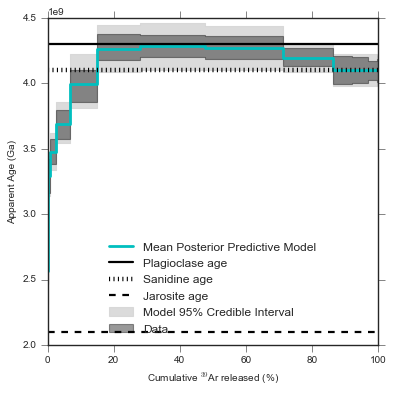

In [708]:

sns.set_style('ticks')
plt.figure(figsize = (5,5))
# Model 
plt.plot(data2*100, w, lw = 2.5, drawstyle = 'steps', color = 'c', 
        label = 'Mean Posterior Predictive Model')
plt.fill_between(data2*100, low, high, color = 'lightgrey', alpha = 0.8, 
                 step = 'pre',
                label = 'Model 95% Credible Interval')

#Dat
plt.fill_between(data2*100, age_m - err, age_m + err,
                step = 'pre', color ='k', 
                 alpha = 0.4, edgecolor= 'k', label = 'Data') 
plt.axhline(4.3e9,lw = 2, color = 'k', 
           ls = '-', 
           label = 'Plagioclase age')
plt.axhline(4.1e9,lw = 4, color = 'k', 
           ls = ':', 
           label = 'Sanidine age')
plt.axhline(2.1e9, lw = 2, color = 'k', 
           ls = '--', 
           label = 'Jarosite age')

plt.ylabel('Apparent Age (Ga)')
plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.legend(loc = 8) 
plt.tight_layout()
plt.xlim(0, 100)
plt.savefig('Tpeak_age_spec.pdf')

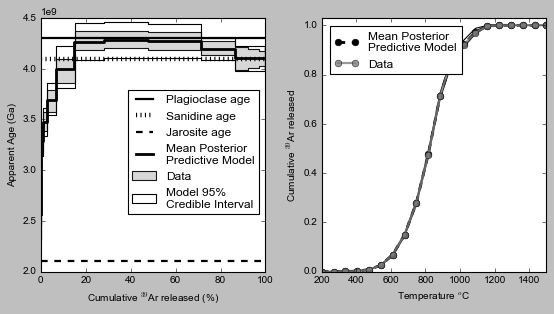

In [709]:

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 9}

plt.style.use('classic')
plt.rc('font', **font)
fig,ax = plt.subplots(1,2, figsize = (7, 4))
# Fractional Release
ax[1].plot(temp - 273.15, w2, '--o', color = 'k',
           lw = 2.5, alpha = 1,
          label = 'Mean Posterior\nPredictive Model')
ax[1].plot(temp -273.15, data2, '-o', label = 'Data', color= 'grey',lw = 2,
          alpha = 0.8)
ax[1].fill_between(temp - 273.15, low2, high2, 
                color = 'None', alpha =  1, edgecolor = 'k')
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xlabel('Temperature $^{o}$C')
ax[1].set_ylabel('Cumulative $^{39}$Ar released')

ax[1].plot(data2*100, w, lw = 2.5, drawstyle = 'steps', color = 'k')
ax[1].fill_between(data2*100, low, high, color = 'None', alpha = 1,
                   edgecolor = 'k',
                 step = 'pre')

ax[1].set_xlim(temp.min() - 273.15, temp.max() - 273.15)

#Age Spectra
ax[0].fill_between(data2*100, age_m - err, age_m + err,
                step = 'pre', color ='lightgrey', 
                 alpha = 0.9, edgecolor= 'k', label = 'Data') 
ax[0].axhline(4.3e9,lw = 2, color = 'k', 
           ls = '-', 
           label = 'Plagioclase age')
ax[0].axhline(4.1e9,lw = 4, color = 'k', 
           ls = ':', 
           label = 'Sanidine age')
ax[0].axhline(2.1e9, lw = 2, color = 'k', 
           ls = '--', 
           label = 'Jarosite age')

ax[0].plot(w2*100, trace['age_model'].mean(axis = 0), lw = 2.5, drawstyle = 'steps', color = 'k', 
        label = 'Mean Posterior\nPredictive Model')
ax[0].fill_between(data2*100, low, high, color = 'None', alpha = 1,
                   edgecolor = 'k',
                 step = 'pre',
                label = 'Model 95%\nCredible Interval')

ax[0].set_ylabel('Apparent Age (Ga)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].legend(bbox_to_anchor = (1, 0.74)) 
ax[1].legend(bbox_to_anchor = (0.65, 0.99))
ax[0].set_xlim(0, 100)
ax[1].set_ylim(0,1.03)
plt.tight_layout()
plt.savefig('TelePeak_age_frel2.pdf')


# AGES

In [710]:
print(np.round(trace['age1'][-1000:].mean(axis = 0))/1e9)
print(2*np.std(trace['age1'][-1000:]/1e9))



2.235447822
0.3417272490253051


In [711]:
print(np.round(trace['age2'][-1000:].mean(axis = 0))/1e9)
print(2*np.std(trace['age2'][-1000:]/1e9))

4.320609606
0.19189246699271695


In [712]:
print(np.round(trace['age3'][-1000:].mean(axis = 0))/1e9)
print(2*np.std(trace['age3'][-1000:]/1e9))

0.14/4.1

4.106890823
0.12698710975948682


0.034146341463414644

In [713]:
trace['phi'].mean(axis = 0)

array([0.04957034, 0.74068804, 0.20974161])

(<matplotlib.axes._subplots.AxesSubplot at 0x1c63da7cf8>, GridSpec(2, 2))

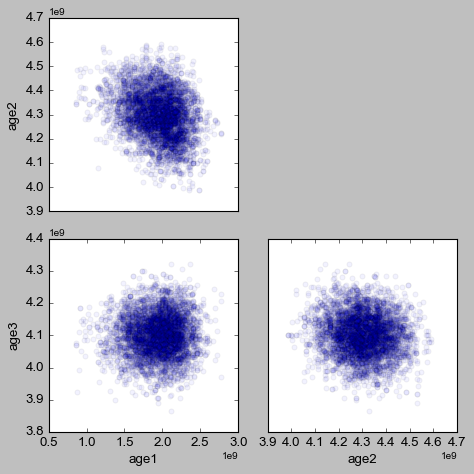

In [718]:
pm.pairplot(trace[-5000::2], varnames = ['age1', 'age2', 'age3'], 
           figsize = (6,6), 
           alpha = 0.05)

In [719]:
# DataFrames for plotting 
df = pd.DataFrame({"frel": w2, 
                  "low_frel":low2, 
                  "high_frel":high2, 
                  "age_model":w,
                  "low_age_m":low, 
                  "high_age_m":high})
df.to_csv("TelePeak_model.csv")

In [720]:
df2 = pm.trace_to_dataframe(trace)
df2.to_csv('TelePeak_trace.csv')

In [723]:
import matplotlib.tri as tri
from scipy import stats as st

from functools import reduce
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
        for i in range(3)]


def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    _, axes = plt.subplots(1,2,figsize=(9, 6))
    if barycentric is True:
        X = X.dot(_corners)
        
    sns.kdeplot(X[:, 0], X[:,1], shade=True, shade_lowest=True, 
                ax=axes[0])
    axes[1].plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    for ax in axes:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        ax.axis('equal')
        ax.axis('on')
        if border is True:
            ax.triplot(_triangle, linewidth=1)

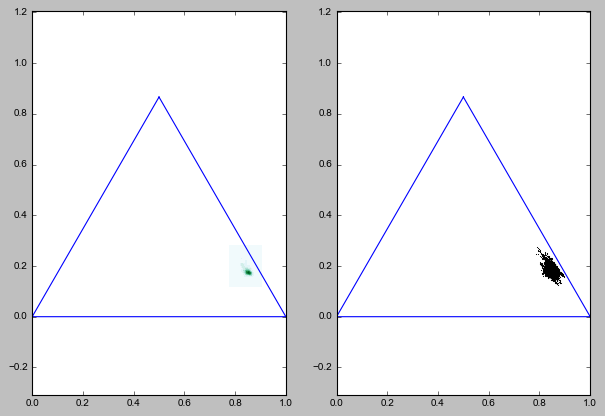

In [724]:
plot_points(trace['phi'][-SAMPLES::10])

In [725]:
dfp = pd.DataFrame({"age1":df2['age1'].values, 
                   "age2": df2['age2'].values, 
                    "age3":df2['age3'].values,
                    "ea1":df2['ea1'].values,
                    "ea2":df2['ea2'].values,
                    "ea3":df2['ea3'].values, 
                    "d01":df2['d01'].values, 
                    "d02":df2['d02'].values, 
                    "d03":df2['d03'].values
                   })

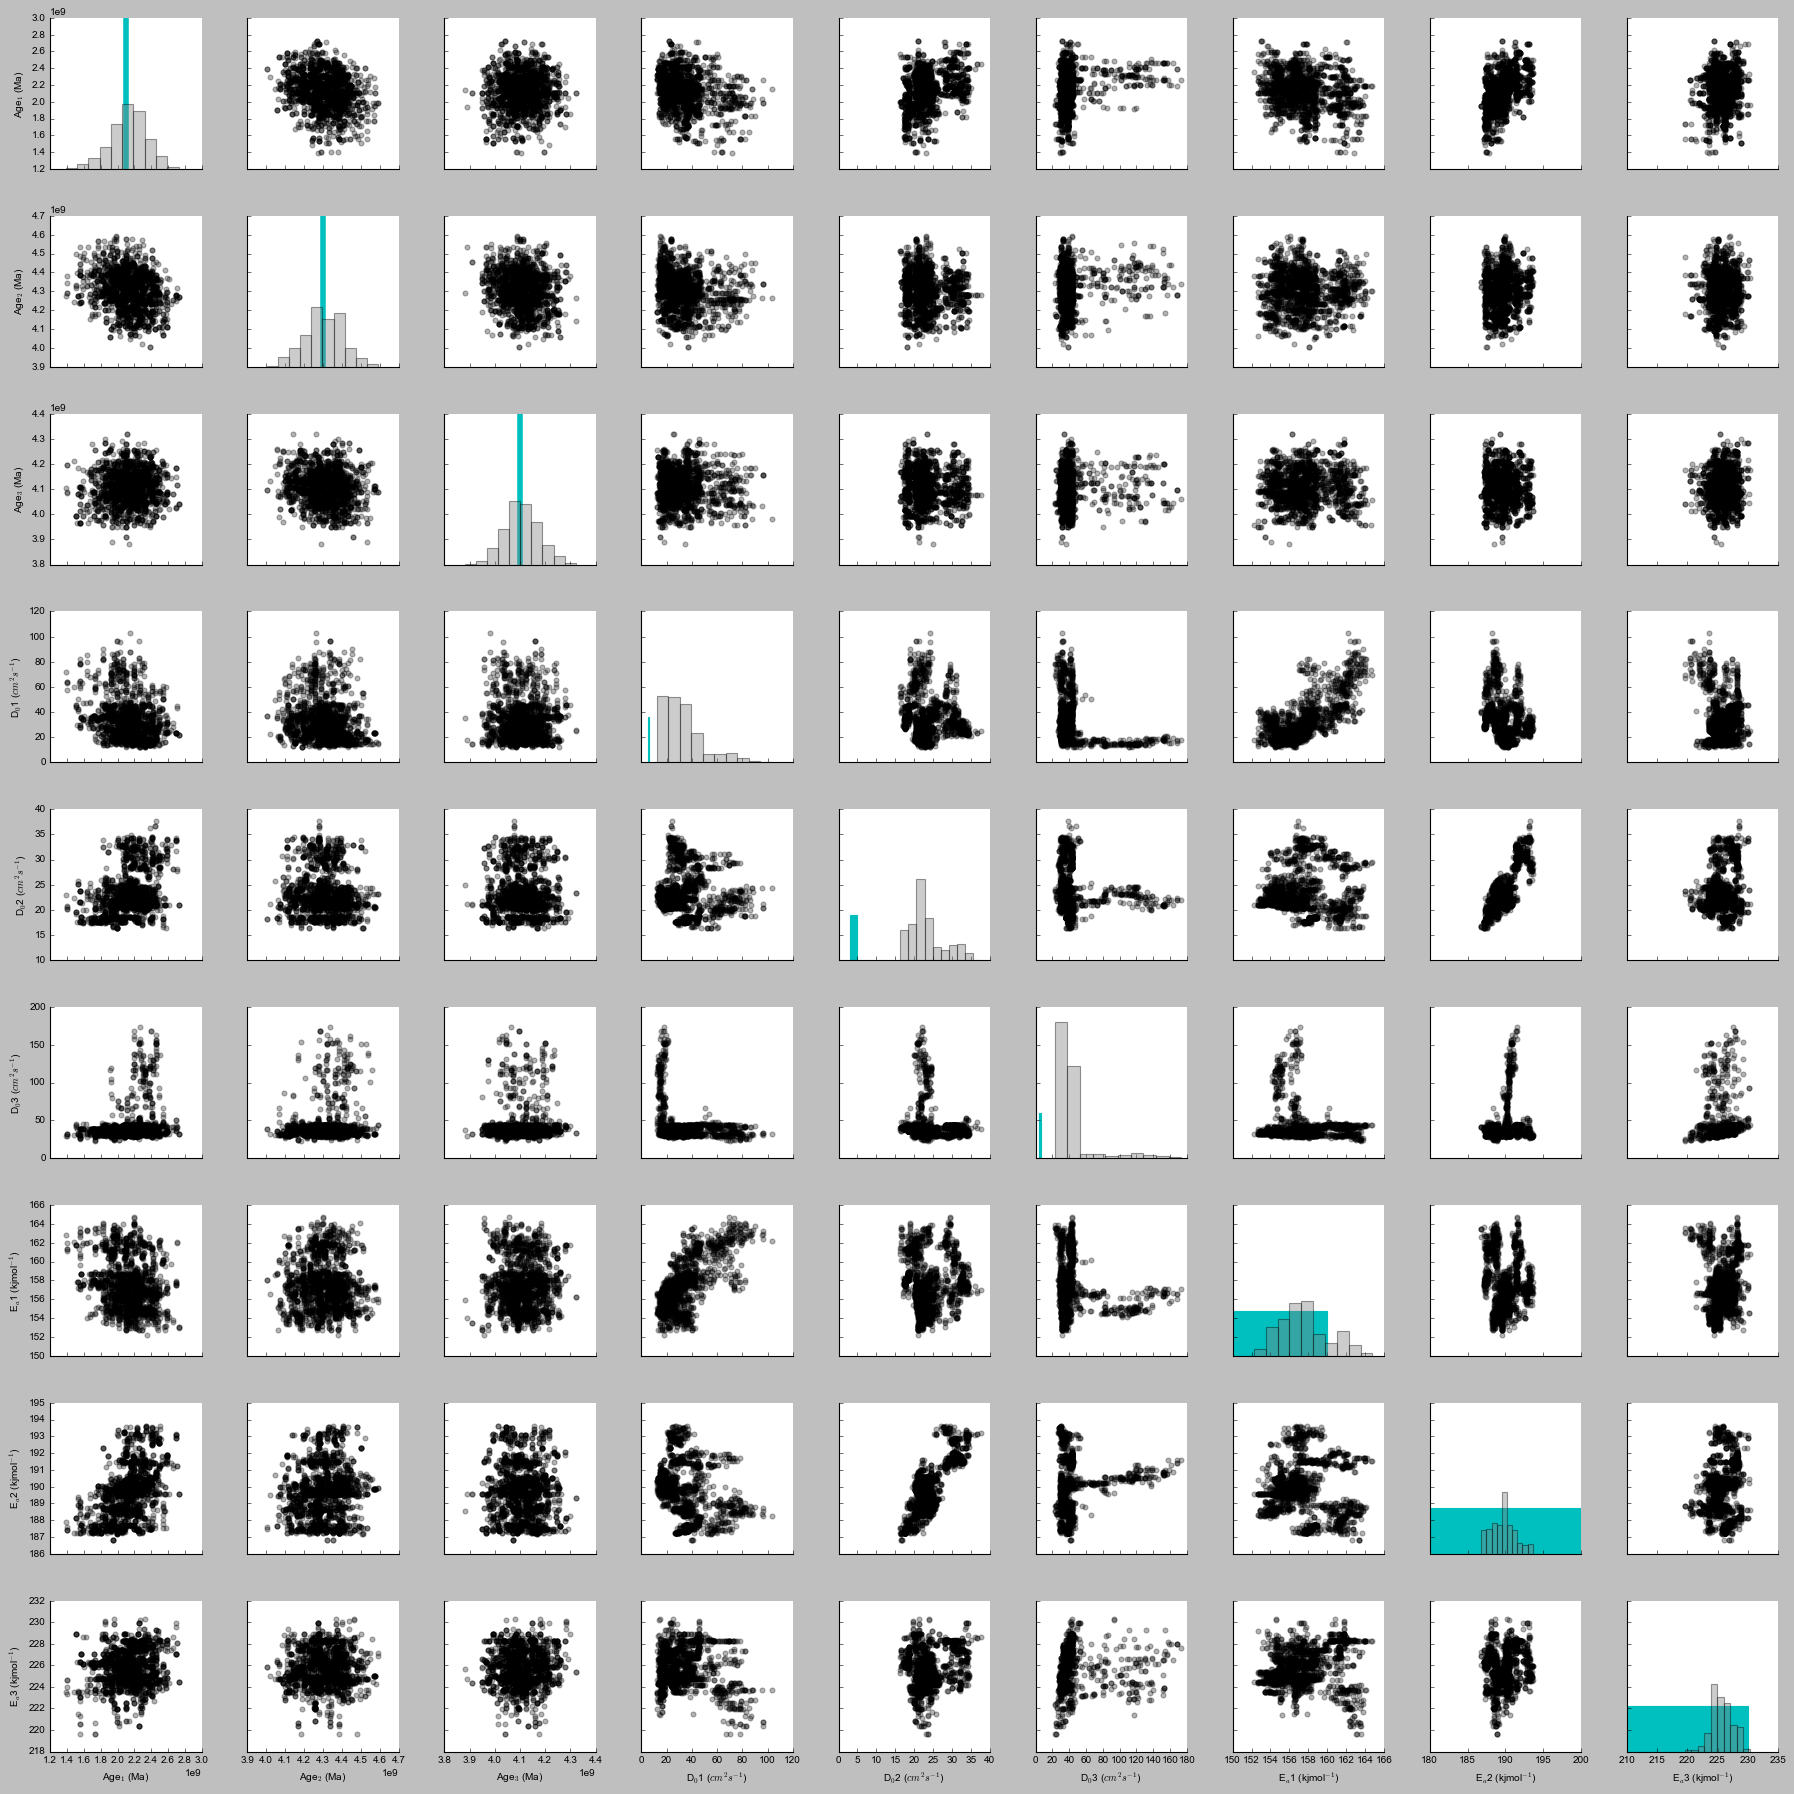

In [726]:
g = sns.PairGrid(dfp[-2000:])
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.4)
g = g.map_offdiag(plt.scatter, alpha = 0.3, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('Age$_3$ (Ma)')
g.axes[3,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,0].set_ylabel('D$_0$3 ($cm^{2}s^{-1}$)')
g.axes[6,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[7,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')
g.axes[8,0].set_ylabel('E$_a$3 (kjmol$^{-1}$)')




# X_AXIS LABELS

g.axes[8,0].set_xlabel('Age$_1$ (Ma)')
g.axes[8,1].set_xlabel('Age$_2$ (Ma)')
g.axes[8,2].set_xlabel('Age$_3$ (Ma)')
g.axes[8,3].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[8,4].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[8,5].set_xlabel('D$_0$3 ($cm^{2}s^{-1}$)')
g.axes[8,6].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[8,7].set_xlabel('E$_a$2 (kjmol$^{-1}$)')
g.axes[8,8].set_xlabel('E$_a$3 (kjmol$^{-1}$)')

g.axes[0,0].axvline(2.1e9, lw = 5, color = 'c')
g.axes[1,1].axvline(4.3e9, lw = 5, color = 'c')
g.axes[2,2].axvline(4.1e9, lw = 5, color = 'c')
g.axes[3,3].axvspan(5, 6,ymax = 0.3, color = 'c')
g.axes[4,4].axvspan(3,5,ymax = 0.3, color = 'c')
g.axes[5,5].axvspan(4, 6,ymax = 0.3, color = 'c')
g.axes[6,6].axvspan(150, 160, ymax = 0.3, color = 'c')
g.axes[7,7].axvspan(180, 200, ymax = 0.3, color = 'c')
g.axes[8,8].axvspan(210, 230, ymax = 0.3, color = 'c')



plt.tight_layout()
plt.savefig('telepeak_pairgrid.pdf')